# Oil Seep Detection 

In [1]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from keras.optimizers import *
from keras.callbacks import *
from keras.losses import *

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import glob
import cv2
import os

Using TensorFlow backend.


In [2]:
tf.test.is_gpu_available()

True

## Explore Dataset

In [3]:
def plot_image_mask(img, mask):
    fig, ax = plt.subplots(1,2, figsize=(12,8))
    
    ax[0].imshow(img)
    ax[0].set_title("Seep Image")

    ax[1].imshow(mask)
    ax[1].set_title("Mask")

    plt.show()

(790, 256, 256, 3)


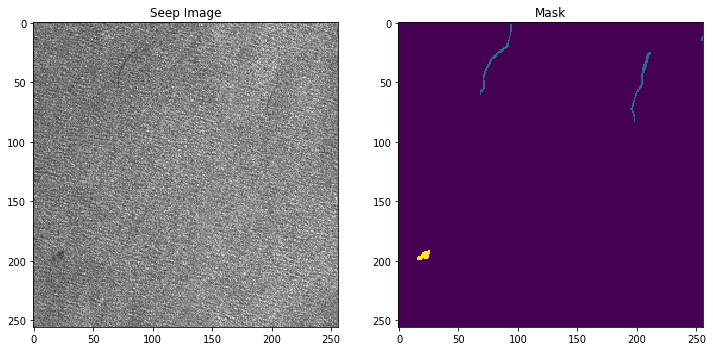

In [4]:
idx = 1

img_path = "seep_detection/images/train_images_256/"
mask_path = "seep_detection/masks/train_masks_256/"

images = []
masks = []

for filename in os.listdir(img_path):
  images.append(cv2.cvtColor(cv2.imread(img_path + filename), cv2.COLOR_BGR2RGB))
  masks.append(plt.imread(mask_path + filename))

images = np.array(images)
masks = np.array(masks)

print(images.shape)
plot_image_mask(images[idx], masks[idx])

In [5]:
print("Dataset Size: {}".format(len(images)))

Dataset Size: 790


## Preprocess Data 

In [6]:
images_process = (images / 255)
masks_process = (np.expand_dims(masks, -1) > 0).astype(np.float64)

X_train, X_test, y_train, y_test = train_test_split(images_process, masks_process, test_size=0.2, random_state=1)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

print("Images Shape: ", images_process.shape)
print("Masks Shape: ", masks_process.shape)

print("Training Samples: {}".format(len(y_train)))
print("Validation Samples: {}".format(len(y_val)))
print("Testing Samples: {}".format(len(y_test)))

Images Shape:  (790, 256, 256, 3)
Masks Shape:  (790, 256, 256, 1)
Training Samples: 632
Validation Samples: 79
Testing Samples: 79


In [8]:
batch_size = 16

# we create two instances with the same arguments
data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     horizontal_flip=True,
                     fill_mode='constant',
                     cval=0,)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1

image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

image_generator = image_datagen.flow(
    X_train, 
    batch_size=batch_size,
    shuffle=True,
    seed=seed)

mask_generator = mask_datagen.flow(
    y_train, 
    batch_size=batch_size,
    shuffle=True,
    seed=seed)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

## Validate Preprocessing

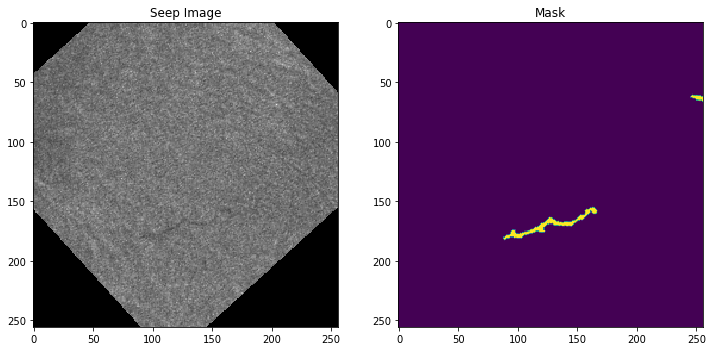

In [9]:
for img, mask in train_generator:
    mask_test = mask[0][:,:,0]
    img_test = img[0]
    break

plot_image_mask(img_test, mask_test)

## Modeling

In [11]:
from models import *


# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric

def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)
  
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

model = unet((256, 256, 3))

model.compile(optimizer=Adam(lr=0.001), loss=bce_dice_loss, metrics=[my_iou_metric, dice_coef, 'acc'])

# model.summary()

## Training

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train)//batch_size,
    validation_data=(X_val, y_val),
    validation_steps=100,
    callbacks=[early_stopping],
    epochs=100)

Epoch 1/100
39/39 [==============================] - 69s 2s/step - loss: 1.2531 - my_iou_metric: 0.0000e+00 - dice_coef: 0.0430 - acc: 0.9474 - val_loss: 1.3662 - val_my_iou_metric: 0.0000e+00 - val_dice_coef: 0.0281 - val_acc: 0.8880
Epoch 2/100
39/39 [==============================] - 14s 359ms/step - loss: 1.0510 - my_iou_metric: 0.0058 - dice_coef: 0.1069 - acc: 0.9733 - val_loss: 1.6915 - val_my_iou_metric: 0.0000e+00 - val_dice_coef: 0.0585 - val_acc: 0.6768
Epoch 3/100
39/39 [==============================] - 13s 337ms/step - loss: 0.9237 - my_iou_metric: 0.0248 - dice_coef: 0.1833 - acc: 0.9747 - val_loss: 1.0194 - val_my_iou_metric: 0.0025 - val_dice_coef: 0.0781 - val_acc: 0.9828
Epoch 4/100
39/39 [==============================] - 13s 337ms/step - loss: 0.7800 - my_iou_metric: 0.0593 - dice_coef: 0.2930 - acc: 0.9789 - val_loss: 1.1654 - val_my_iou_metric: 0.0190 - val_dice_coef: 0.1690 - val_acc: 0.9195
Epoch 5/100
39/39 [==============================] - 13s 337ms/step - l

## Evaluate Training Results

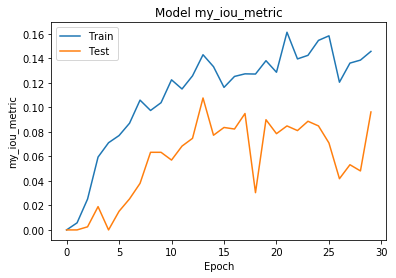

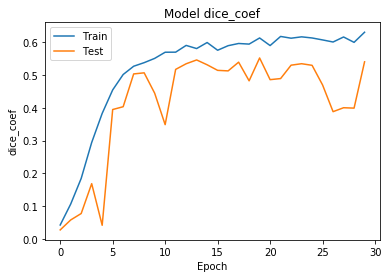

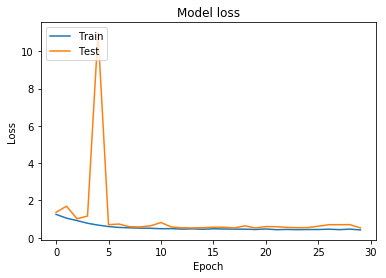

In [14]:
# # Plot training & validation accuracy values
plt.plot(history.history['my_iou_metric'])
plt.plot(history.history['val_my_iou_metric'])
plt.title('Model my_iou_metric')
plt.ylabel('my_iou_metric')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# # Plot training & validation accuracy values
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
def plot_test_mask(img, true, pred):
    fig, ax = plt.subplots(1,3, figsize=(12,8))
    
    ax[0].imshow(img)
    ax[0].set_title("Seep Image")

    ax[1].imshow(true)
    ax[1].set_title("True Mask")
    
    ax[2].imshow(pred)
    ax[2].set_title("Pred Mask")

    plt.show()




Sample 0


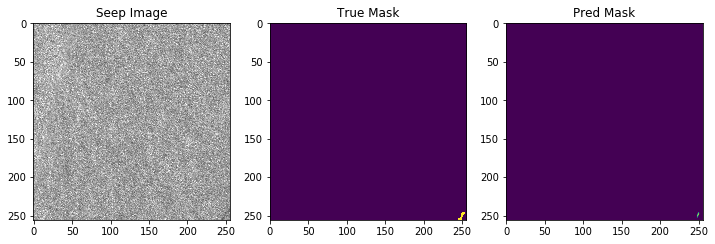




Sample 1


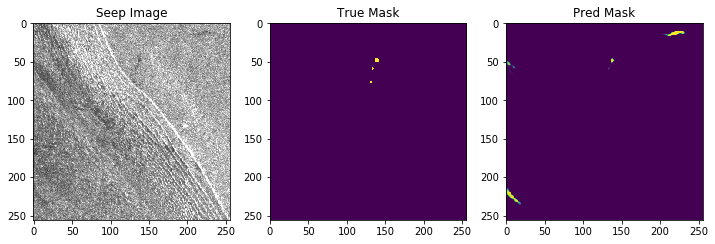




Sample 2


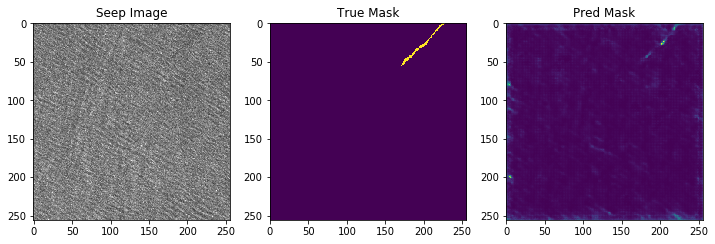




Sample 3


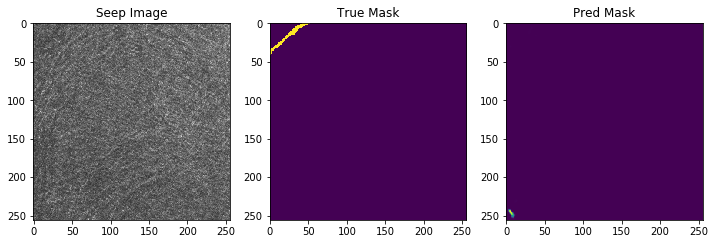




Sample 4


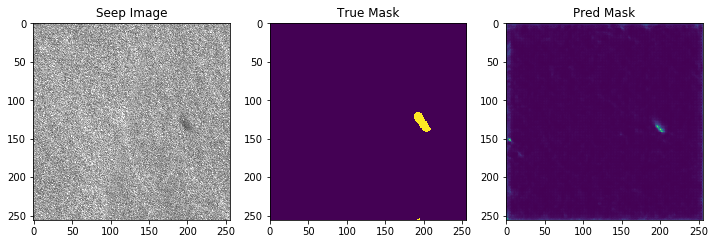




Sample 5


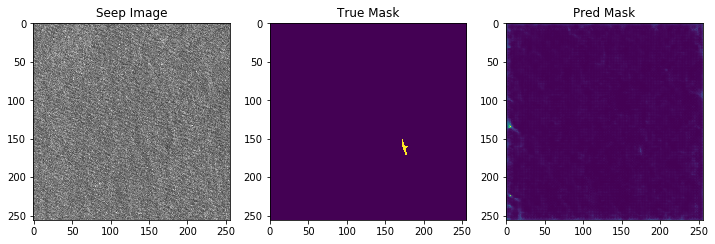




Sample 6


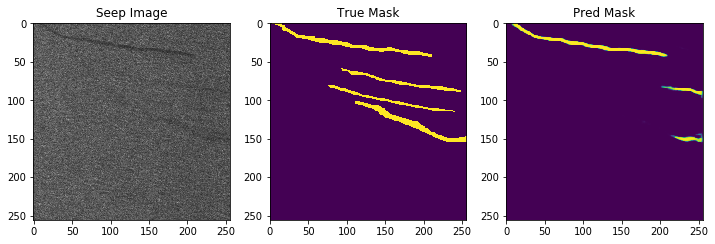




Sample 7


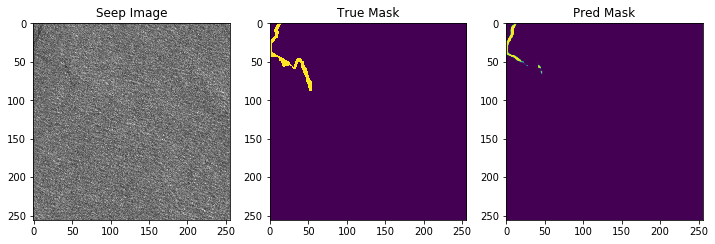




Sample 8


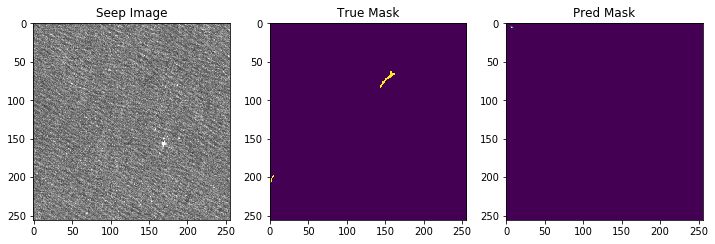




Sample 9


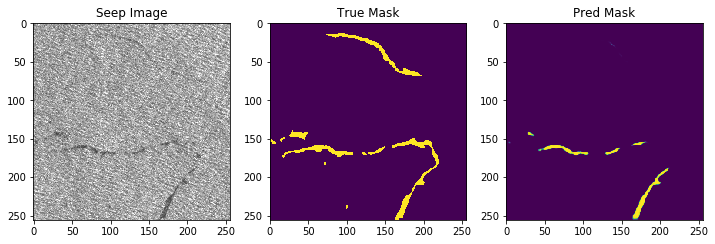




Sample 10


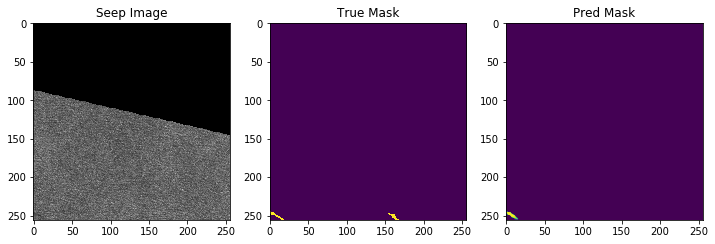




Sample 11


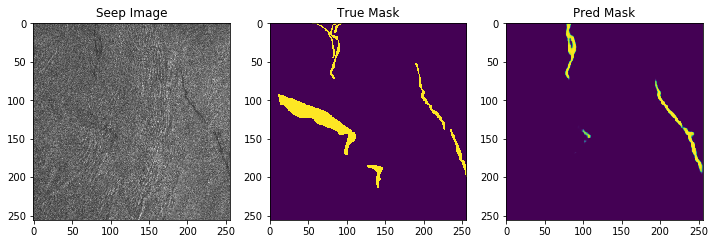




Sample 12


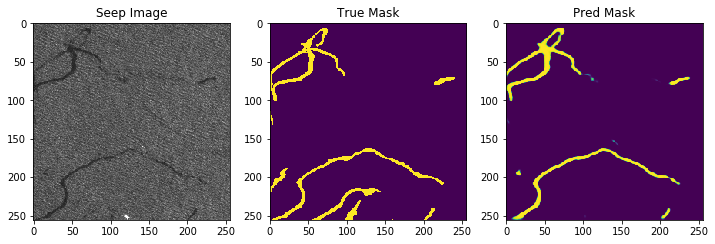




Sample 13


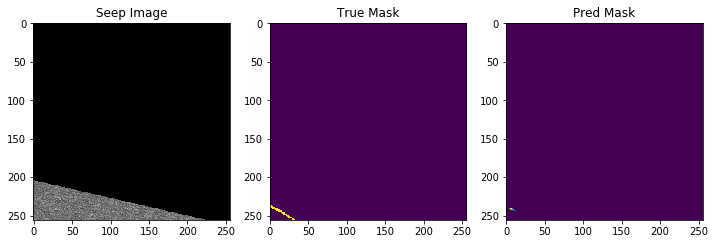




Sample 14


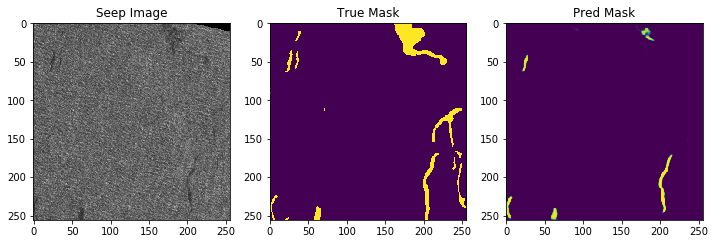

In [23]:
preds = model.predict(X_test)

for idx in range(15):
    print("\n\n\nSample {}".format(idx))
    plot_test_mask(X_test[idx], y_test[idx][:,:,0], preds[idx][:,:,0])


In [27]:
test_loss, test_iou, test_dice_coef, test_acc = model.evaluate(X_test, y_test)

print("\nTest Loss: {}".format(test_loss))
print("Test IoU: {}".format(test_iou))
print("Test Dice Coefficient: {}".format(test_dice_coef))
print("Test Accuracy: {}".format(test_acc))

79/79 [==============================] - 0s 6ms/step

Test Loss: 0.5195042973832239
Test IoU: 0.06835443037974683
Test Dice Coefficient: 0.5540732696086546
Test Accuracy: 0.9880394271657437


In [28]:
model.save("model-dcoef0.55.h5")